# How to think about treating heterogeneous initial populations

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import sys
import pickle
from pyDOE import *
from scipy.stats.distributions import norm
import scipy.optimize as sp

In [8]:
u_N = .02
u_SCM = .005
u_TM = 0.32
u_CM = 0.35
u_EM = 0.30
u_EMRA = 0.005
std = 0.1
u_T = [u_N, 0, u_SCM,0, u_TM,0, u_CM, 0,u_EM,0,u_EMRA,0]

In [3]:
sims = 10000
design = lhs(12, samples=sims)
means = u_T
stdvs = [std,0]*6
for i in range(12):
    design[:, i] = norm(loc=means[i], scale=stdvs[i]).ppf(design[:, i])

design[~(abs(design)>0)] = 0
sim_init = abs(design)

/home/qiuwu/anaconda3/envs/scanpy_env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1910: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/home/qiuwu/anaconda3/envs/scanpy_env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1911: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc
/home/qiuwu/anaconda3/envs/scanpy_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


In [4]:
# Set plotting parameters
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

## Define Model

In [5]:
#Define the model
def model(z,t):
    L_n = z[0]
    L_scm = z[2]
    L_tm = z[4]
    L_cm = z[6] 
    L_em = z[8]
    L_emra = z[10]
    
    A_n = z[1]
    A_scm = z[3]
    A_tm = z[5]
    A_cm = z[7]
    A_em = z[9]
    A_emra = z[11]
    
    
    #for drug dosings
    dL_ndt = (p_n - d_n)*L_n - a*L_n + w*A_n
    dA_ndt = a*L_n - d_ALL*A_n - w*A_n
    
    dL_scmdt = (p_scm - d_scm)*L_scm - a*L_scm + w*A_scm
    dA_scmdt = a*L_scm - d_ALL*A_scm - w*A_scm
    
    dL_tmdt = (p_tm - d_tm)*L_tm - a*L_tm + w*A_tm
    dA_tmdt = a*L_tm - d_ALL*A_tm - w*A_tm
    
    dL_cmdt = (p_cm - d_cm)*L_cm - a*L_cm + w*A_cm
    dA_cmdt = a*L_cm - d_ALL*A_cm - w*A_cm
    
    dL_emdt = (p_em - d_em)*L_em - a*L_em + w*A_em
    dA_emdt = a*L_em - d_ALL*A_em - w*A_em
    
    dL_emradt = (p_emra - d_emra)*L_emra - a*L_emra + w*A_emra
    dA_emradt = a*L_emra - d_ALL*A_emra - w*A_emra
    
    
    dzdt = [dL_ndt,dA_ndt,
            dL_scmdt,dA_scmdt,
            dL_tmdt,dA_tmdt,
            dL_cmdt,dA_cmdt,
            dL_emdt,dA_emdt,
            dL_emradt,dA_emradt
            ]
    return dzdt

In [43]:
parameter_arr = sim_init

#number of time points
tn = 2000

#store solutions
#store solutions
L_n = np.zeros([parameter_arr.shape[0],tn])
L_scm = np.zeros([parameter_arr.shape[0],tn])
L_tm = np.zeros([parameter_arr.shape[0],tn])
L_cm = np.zeros([parameter_arr.shape[0],tn])
L_em = np.zeros([parameter_arr.shape[0],tn])
L_emra = np.zeros([parameter_arr.shape[0],tn])

A_n = np.zeros([parameter_arr.shape[0],tn])
A_scm = np.zeros([parameter_arr.shape[0],tn])
A_tm = np.zeros([parameter_arr.shape[0],tn])
A_cm = np.zeros([parameter_arr.shape[0],tn])
A_em = np.zeros([parameter_arr.shape[0],tn])
A_emra = np.zeros([parameter_arr.shape[0],tn])
Total = np.zeros([parameter_arr.shape[0],tn])




for i,parameter in enumerate(parameter_arr):
#initial conditions, there are three
    w = 1/20 # In Ke's 2015 paper, it looks like a reasonable assumption is 20-50 days because thats where copies of vRNA start dropping
    d = 1
    LRA = 1
    d_ALL = 0.003

    p_cm = 0.00075 * d
    p_tm = 0.0006 * d
    p_em = 0.0003 * d
    p_n = 0.000099 * d
    p_scm = 0.00001 * d
    p_emra = 0.00005 * d


    corr_fact = -np.log(1/2)
    d_n = corr_fact * (1/1500)
    d_scm = corr_fact * (1/150)
    d_tm = corr_fact * (1/100)
    d_cm = corr_fact * (1/120)
    d_em = corr_fact * (1/90)
    d_emra = corr_fact * (1/250)
    n = 0.00017
    a = n * LRA

    
    z0 = parameter*10**6

    #time points
    b = 2000
    tn = 60001
    t = np.linspace(0,tn-1, b)


    #record intial

    L_n[i][0] = z0[0]
    L_scm[i][0] = z0[2]
    L_tm[i][0] = z0[4]
    L_cm[i][0] = z0[6] 
    L_em[i][0] = z0[8]
    L_emra[i][0] =z0[10]

    A_n[i][0] = z0[1]
    A_scm[i][0] = z0[3]
    A_tm[i][0] = z0[5]
    A_cm[i][0] = z0[7]
    A_em[i][0] = z0[9]
    A_emra[i][0] = z0[11]

    Total[i][0] = np.sum(z0)

    #Solve the ODE
    for k in range(1,b):
        tspan = [t[k-1],t[k]]
        # solve for next step
        z = odeint(model,z0,tspan)
        # store solution for plotting

        L_n[i][k] = z[1][0]
        L_scm[i][k] = z[1][2]
        L_tm[i][k] = z[1][4]
        L_cm[i][k] = z[1][6] 
        L_em[i][k] = z[1][8]
        L_emra[i][k] = z[1][10]

        A_n[i][k] = z[1][1]
        A_scm[i][k] = z[1][3]
        A_tm[i][k] = z[1][5]
        A_cm[i][k] = z[1][7]
        A_em[i][k] = z[1][9]
        A_emra[i][k] = z[1][11]


        Total[i][k] =np.sum(z[1])
        z0 = z[1] 
    sys.stdout.write('\r {}'.format(i) )
    
t = t/365
pop_dict = {}
pop_dict['latent'] = [L_n, L_scm, L_tm, L_cm, L_em, L_emra]
pop_dict['active'] = [A_n, A_scm, A_tm, A_cm, A_em, A_emra]
pop_dict['times'] = t
pop_dict['total'] = Total
pop_dict['cell_type'] = ['T_n', 'T_scm', 'T_tm', 'T_cm','T_em', 'T_emra']



 9999

In [44]:
pop_dict['sim'] = sim_init

In [45]:
#pickle.dump(pop_dict,open('190501_pop_sensitivity.p', 'wb'))

In [9]:
pop_dict = pickle.load(open('190501_pop_sensitivity.p', 'rb'))

UnpicklingError: pickle data was truncated

In [49]:
hy_list = []
for i in range(sims):
    a = np.where(pop_dict['total'][i] < 10**2)[0]
    hy_list.append(t[a[0]])

In [242]:
def func(x, a, b, c,d,e):
    return a * np.log(b * x)  +  c*np.log(d * x) + e

x,y = sp.curve_fit(func, sim_init.T[0], hy_list)

/home/qiuwu/anaconda3/envs/scanpy_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


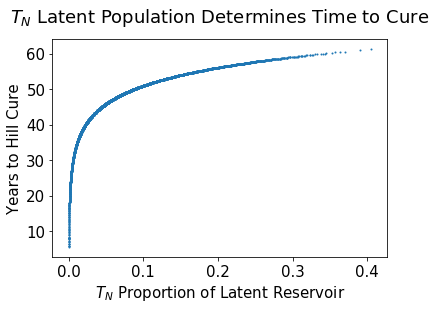

In [174]:
plt.scatter(sim_init.T[0], hy_list, s = 1)
plt.xlabel(r'$T_N$ Proportion of Latent Reservoir')
plt.ylabel('Years to Hill Cure')
ttl = plt.title(r'$T_N$ Latent Population Determines Time to Cure', y = 1.05)

/home/qiuwu/anaconda3/envs/scanpy_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


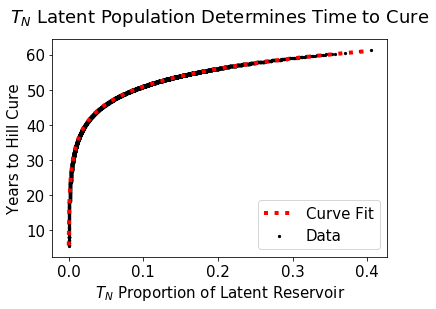

In [255]:
h = np.linspace(0,0.4,2000)
plt.plot(h, func(h, x[0], x[1],x[2],x[3],x[4]), linewidth = 4, c = 'red', linestyle = ':', label = 'Curve Fit')

plt.scatter(sim_init.T[0], hy_list, s = 5, label = 'Data', c = 'k')
plt.xlabel(r'$T_N$ Proportion of Latent Reservoir')
plt.ylabel('Years to Hill Cure')
ttl = plt.title(r'$T_N$ Latent Population Determines Time to Cure', y = 1.05)
plt.legend()

(0, 0.08)

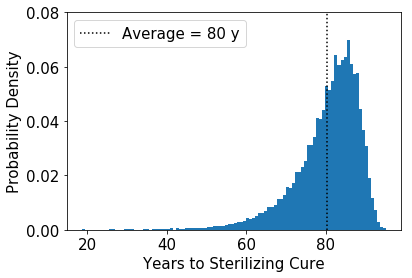

In [342]:
one_arr = np.zeros(sims)
for i in range(sims):
    a = pop_dict['total'][i] < 1
    one_arr[i] = t[np.where(a)][0]

one_mean = np.mean(one_arr)
one_arr_hist = plt.hist(one_arr, bins = 100, density = True)
plt.vlines(one_mean, 0, 0.08, linestyle = ':', label = 'Average = {} y'.format(int(one_mean)))
plt.xlabel('Years to Sterilizing Cure')
plt.ylabel('Probability Density')
plt.legend()
plt.ylim([0,0.08])

In [267]:
import scipy.stats as stats
stats.describe(one_arr)

DescribeResult(nobs=10000, minmax=(18.66686768041555, 95.22569503930048), mean=80.39198229251612, variance=66.87787512547926, skewness=-1.511662394359517, kurtosis=3.7156182435456158)

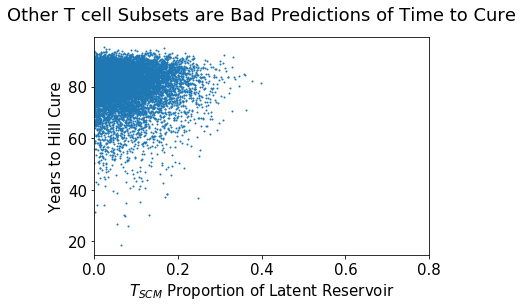

In [347]:
plt.scatter(sim_init.T[2], one_arr, s = 1)
plt.xlim([0,.8])
plt.xlabel(r'$T_{SCM}$ Proportion of Latent Reservoir')
plt.ylabel('Years to Hill Cure')
ttl = plt.title(r'Other T cell Subsets are Bad Predictions of Time to Cure', y = 1.05)

(0, 0.08)

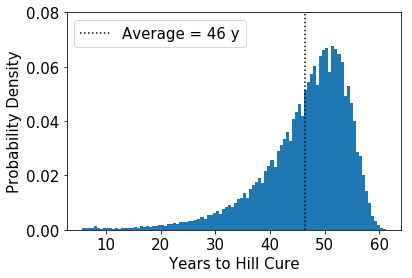

In [341]:
one_arr = np.zeros(sims)
for i in range(sims):
    a = pop_dict['total'][i] < 10**2
    one_arr[i] = t[np.where(a)][0]

one_mean = np.mean(one_arr)
one_arr_hist = plt.hist(one_arr, bins = 100, density = True)
plt.vlines(one_mean, 0, 0.08, linestyle = ':', label = 'Average = {} y'.format(int(one_mean)))
plt.xlabel('Years to Hill Cure')
plt.ylabel('Probability Density')
plt.legend()
plt.ylim([0,0.08])